# Diagram difference with synthetic data

In this notebook, diagram differences, defined by histogram distance (Cha and Srihari (2002)) will be calculated using synthetic seismogram data.

## 1. Parameter definition

Model and measurement parameters are defined. Here, we have an example of a three-layer medium.

In [15]:
import numpy as np

#-> model parameters
thk = np.array([3.0, 5.0, 0], dtype = float) # the third layer is semi-infinite, thickness = 0 by default
dns = np.array([1000.0, 1500.0, 1700.0], dtype = float) # density
cvp = np.array([1100.0, 1300.0, 2000.0], dtype = float) # P-wave
cvs = np.array([600.0, 900.0, 1100.0], dtype = float) # S-wave

#-> time 
dt = 100/1e6           # sampling time
nt, ntraces = 5400, 90 # time vector length; number of receivers
t = np.linspace(0, (nt-1)*dt, nt) # time vector

#-> receivers
dx = 1          # receiver space
offset = 12     # distance between source and the first receiver
x = np.linspace(offset, (ntraces-1)*dx+offset, ntraces)    # offset vector
X_total = x[-1]-x[0]    # total length of receivers

#-> Ricker wavelet as source signal
from math_func import ricker
signal = ricker(55, 0.05, t)

#-> frequency vector
fmin = 20; fmax = 350
fft_f = np.fft.rfftfreq(nt, dt) #frequency vector for fft
findex = (fft_f>=fmin)&(fft_f<=fmax) 
f = fft_f[findex] #frequency vector within frequency range

#-> velocity vector
vmin = 500; vmax = 1500; nv = 1001
v = np.linspace(vmin, vmax, nv)

## 2. Synthetic data

Generate synthetic seismogram in time-offset domain using "seismo_t_x". Only the fundamental mode of Rayleigh wave phase velocity is considered. 

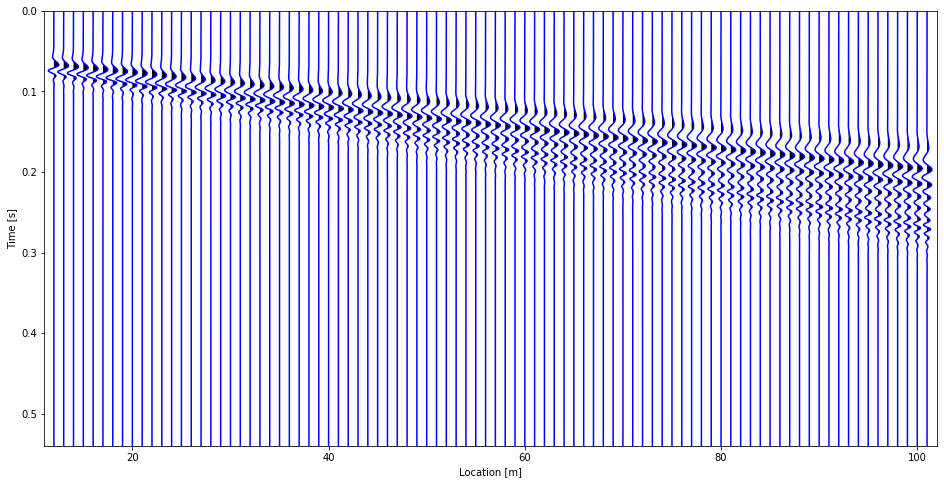

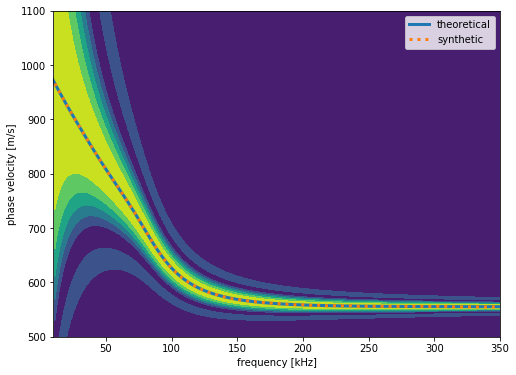

In [6]:
# import 
from math_func import gpdc_calculation, seismo_t_x, seismo_tx_filter, diagram_v_f
from wiggle import wiggles
import matplotlib.pyplot as plt

#-> seismogram without noise
vr = 1/(gpdc_calculation(fft_f[1:], cvp, cvs, dns, thk)[:,1])
stx = seismo_t_x(t, x, signal, vr)
_, vph, diagram = diagram_v_f(stx, x, t, fmin, fmax, vmax, vmin, nv)  

#-> plot seismogram
plt.figure(figsize=[16, 8])
wiggles(stx, t, x, plt.gca(), overlap=0, polarity=True, color=False, lineColor = 'blue', fill=True)

#-> plot dispersion diagram and dispersion curve
plt.figure(figsize = [8,6])
plt.xlabel("frequency [kHz]"); plt.ylabel("phase velocity [m/s]")
plt.xlim([fmin, fmax])
plt.plot(fft_f[1:], vr, linewidth = 3, label = "theoretical")
plt.plot(f, vph, linewidth = 3, label = "synthetic", linestyle = ":")
plt.contourf(f,v,diagram)
plt.legend()

Random noise can be added in "seismo_t_x" by the singal-to-noise ratio.

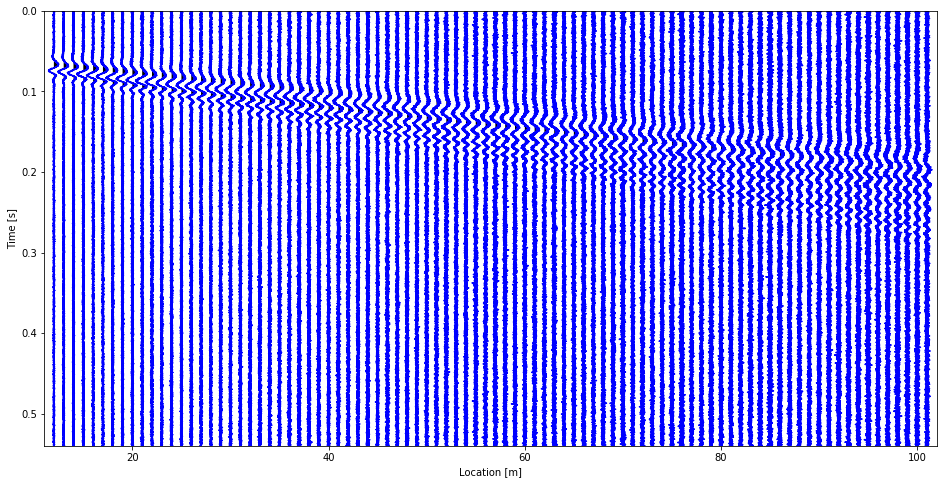

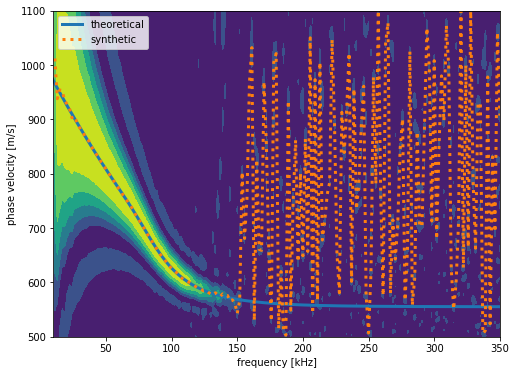

In [7]:
# signal-to_noise ratio
noise_ratio = 0.3

stx_noise = seismo_t_x(t, x, signal, vr, noise_ratio)
_, vph_noise, diagram_noise = diagram_v_f(stx_noise, x, t, fmin, fmax, vmax, vmin, nv)  

#-> plot seismogram
plt.figure(figsize=[16, 8])
wiggles(stx_noise, t, x, plt.gca(), overlap=0, polarity=True, color=False, lineColor = 'blue', fill=True)

#-> plot dispersion diagram and dispersion curve
plt.figure(figsize = [8,6])
plt.xlabel("frequency [kHz]"); plt.ylabel("phase velocity [m/s]")
plt.xlim([fmin, fmax])

plt.plot(fft_f[1:], vr, linewidth = 3, label = "theoretical")
plt.plot(f, vph_noise, linewidth = 3, label = "synthetic", linestyle = ":")
plt.contourf(f,v,diagram_noise)
plt.legend()

For time-saving consideration, there is no need to generate a seismogram at the whole fft frequency range [0, fs/2]. "seismo_tx_filter" generate a seismogram at a given frequency range [fmin, fmax], thus saving the loop time.

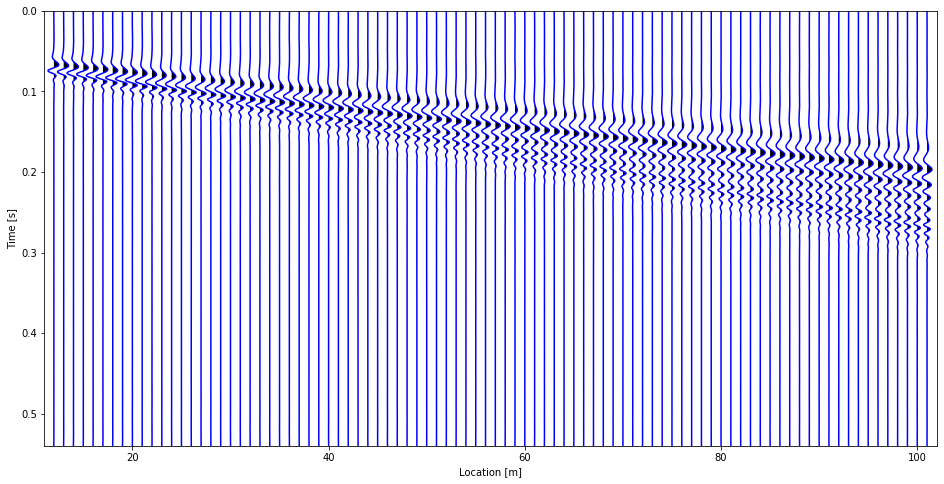

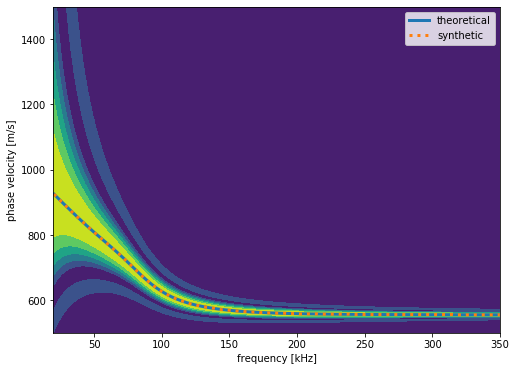

In [16]:
from math_func import seismo_tx_filter

#-> Vph is calculated in [fmin, fmax] range
vr_filter = 1/(gpdc_calculation(f, cvp, cvs, dns, thk)[:,1])
stx_filter = seismo_tx_filter(t, x, signal, vr_filter, fmin, fmax)
_, vph_filter, diagram_filter = diagram_v_f(stx_filter, x, t, fmin, fmax, vmax, vmin, nv)  

#-> plot seismogram
plt.figure(figsize=[16, 8])
wiggles(stx_filter, t, x, plt.gca(), overlap=0, polarity=True, color=False, lineColor = 'blue', fill=True)

#-> plot dispersion diagram and dispersion curve
plt.figure(figsize = [8,6])
plt.xlabel("frequency [kHz]"); plt.ylabel("phase velocity [m/s]")
plt.xlim([fmin, fmax])

plt.plot(f, vr_filter, linewidth = 3, label = "theoretical")
plt.plot(f, vph_filter, linewidth = 3, label = "synthetic", linestyle = ":")
plt.contourf(f,v,diagram_filter)
plt.legend()

## 3. Synthetic baseline and repeatline 

Two synthetic data are needed to calculate histogram distance (or the diagram difference) between them.

Model parameters of baseline are provided previously. Repeatline shears the same P-wave velocity, density and layer thickness as beasline, but has 10% variation on the S-wave velocity of the third layer.

Baseline data are calculated previously using "seismo_tx_filter" without noise. Repeatline data will be calculated in the same way.

In [17]:
alpha = 10 # Vs varaition ratio

#-> baseline data
baseline_diagram = diagram_filter.copy()

#-> repeatline data
cvs_repeatline = np.array([cvs[0], cvs[1], cvs[2]*(1+alpha/100)])  

vr_repeatline = 1/(gpdc_calculation(f, cvp, cvs_repeatline, dns, thk)[:,1])
stx_repeatline = seismo_tx_filter(t, x[1:], signal, vr_repeatline, fmin, fmax)
_, _, repeatline_diagram = diagram_v_f(stx_repeatline, x[1:], t, fmin, fmax, vmax, vmin, nv)

## 4. Diagram differences

Use "diagram_distance" to calculate diagram differences of baseline and repeatline. 

In [23]:
from math_func import diagram_distance

#-> frequency and velocity limits at which there is a mode jump (only fundamental mode in our case).  
fmode = fmax
vmode = vmax

L1 = diagram_distance(baseline_diagram, repeatline_diagram, f, v, X_total, "block", fmode, vmode)
L2 = diagram_distance(baseline_diagram, repeatline_diagram, f, v, X_total, "EUC", fmode, vmode)
Correlation = diagram_distance(baseline_diagram, repeatline_diagram, f, v, X_total, "COR", fmode, vmode)
BHA = diagram_distance(baseline_diagram, repeatline_diagram, f, v, X_total, "BHA", fmode, vmode)
KLD = diagram_distance(baseline_diagram, repeatline_diagram, f, v, X_total, "KLD", fmode, vmode)
ORD = diagram_distance(baseline_diagram, repeatline_diagram, f, v, X_total, "ordinary", fmode, vmode)

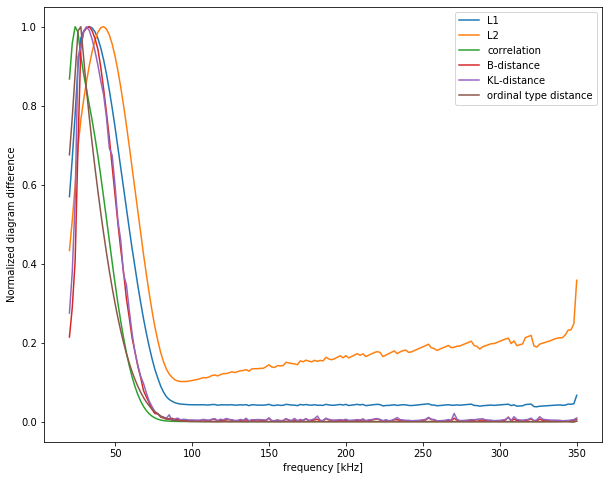

In [26]:
plt.figure(figsize = [10, 8])
plt.xlabel("frequency [kHz]");plt.ylabel("Normalized diagram difference")

plt.plot(f, L1/max(L1), label = "L1")
plt.plot(f, L2/max(L2), label = "L2")
plt.plot(f, Correlation/max(Correlation), label = "correlation")
plt.plot(f, BHA/max(BHA), label = "B-distance")
plt.plot(f, KLD/max(KLD), label = "KL-distance")
plt.plot(f, ORD/max(ORD), label = "ordinal type distance")
plt.legend()

## References

Cha, S.-H. and Srihari, S. N. (2002). On measuring the distance between histograms. Pattern Recognition , 35(6):1355-1370.